# Supervised Learning of Drug Response using CORES from Copy Number Log Ratio

### Import Python source code

In [83]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jul 26 12:21:38 2018

@author: bbece
"""

from __future__ import division, print_function, unicode_literals
import numpy as np
import os
from IPython.display import display, HTML

from pprint import pprint
np.random.seed(42)

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
            
import pandas as pd
import scipy

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler

from sklearn import decomposition

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from sklearn.tree import export_graphviz

import math



### Load training set matrix

In [122]:
#labeled_matrix_training_set = pd.read_csv("../mlOutput/geneTrainingSet_8_5_2018_1.csv") # Cancer gene feature set
#labeled_matrix_training_set = pd.read_csv("../mlOutput/slicingTrainingSet_8_3_2018_1.csv") # Slicing features on A and D combined
labeled_matrix_training_set = pd.read_csv("../mlOutput/coreTrainingSet_8_2_2018_2.csv") # Segment features on A and D combined
#labeled_matrix_training_set = pd.read_csv("../mlOutput/coreTrainingSet_8_2_2018_1.csv") # Segment features on A and D merged
#labeled_matrix_training_set.columns.values[0] = "sampleId"
labeled_matrix_training_set = labeled_matrix_training_set.drop([labeled_matrix_training_set.columns[0]], axis = 1)
labels = list(range(0,5))


In [123]:
display(labeled_matrix_training_set.head(25))

,Gemcitabine,Paclitaxel,SN-38,5-FU,Oxaliplatin,1,3,8,9,16,...,65,67,68,69,70,72,73,74,77,80
0,0.576312,0.715357,0.542345,0.770327,0.875863,0.436093,0.219046,0.093381,0.306327,-0.850429,...,0.091356,-0.020526,0.305247,-0.097172,0.091364,-0.936458,-0.861014,-0.953599,0.979149,-0.069036
1,0.531357,0.481223,0.552329,0.778592,0.802963,0.522301,0.332260,0.036914,0.233745,-0.951033,...,0.037372,-0.353375,-0.111128,-0.611878,-0.351904,-0.289993,-0.324749,-0.375740,-0.263046,-0.427196
2,0.610292,0.748410,0.544124,0.673957,0.790218,0.395108,-0.059497,-0.056061,0.109607,-1.585542,...,-0.121145,-0.175617,-0.052702,-0.425628,0.049563,-0.543270,-0.536459,-0.642908,0.251044,0.088374
3,0.677571,0.647227,0.562632,0.826889,0.835748,0.132817,0.529099,-0.040379,0.202314,-0.619159,...,0.414758,0.183085,0.685537,0.189467,0.549099,-0.637489,-0.642251,-0.772321,0.572187,-1.629346
4,0.694529,0.653745,0.651769,0.850960,0.813800,0.207992,0.265925,0.114829,0.234293,-0.879316,...,0.136851,0.510556,0.287325,0.589296,0.824069,0.011819,-0.754368,-0.047061,0.572734,-1.053957
5,0.625919,0.546421,0.570326,0.723314,0.943585,0.099434,0.458407,0.783488,0.953391,-0.255512,...,-0.189842,-0.323942,-0.132488,-0.580421,-0.107210,-0.253809,-0.300951,-0.355237,1.404891,0.196116
6,0.619415,0.566868,0.548342,0.755120,0.841761,-0.960577,0.375832,-0.173501,0.123302,-0.562097,...,0.025176,-0.390782,-1.956893,-1.476872,-1.255124,0.184695,0.159322,0.046950,-0.203930,-0.807023
7,0.557171,0.577914,0.611604,0.895087,0.914860,-0.334538,0.416808,0.317006,0.459243,-1.689432,...,0.371994,-0.222975,0.139134,-0.357164,-0.004910,-0.180432,-0.212158,-0.218690,0.410748,-1.764445
8,0.821077,0.698895,0.790806,NaN,NaN,-0.557269,0.301038,0.195996,0.364016,-0.690727,...,0.273373,0.029492,0.520527,-0.305875,0.234380,0.191366,0.088789,0.084635,-0.158168,-0.735119
9,NaN,NaN,NaN,NaN,NaN,0.472155,-0.079524,0.286920,0.462819,-0.417980,...,-0.244722,-0.314863,-0.243135,-0.440525,-0.080551,-0.213000,-0.366078,0.475861,0.663687,-0.376184


In [124]:
X = labeled_matrix_training_set.copy().drop(labeled_matrix_training_set.columns[labels], axis = 1)
y = labeled_matrix_training_set.copy()[labeled_matrix_training_set.columns[labels]]

In [125]:
display(X.head())

,1,3,8,9,16,18,22,23,24,30,...,65,67,68,69,70,72,73,74,77,80
0,0.436093,0.219046,0.093381,0.306327,-0.850429,0.054373,0.611854,0.114151,0.196272,0.313453,...,0.091356,-0.020526,0.305247,-0.097172,0.091364,-0.936458,-0.861014,-0.953599,0.979149,-0.069036
1,0.522301,0.332260,0.036914,0.233745,-0.951033,-0.695467,-0.022730,0.508777,-0.047856,-0.052709,...,0.037372,-0.353375,-0.111128,-0.611878,-0.351904,-0.289993,-0.324749,-0.375740,-0.263046,-0.427196
2,0.395108,-0.059497,-0.056061,0.109607,-1.585542,0.027163,-0.101243,-0.467931,0.036215,0.576793,...,-0.121145,-0.175617,-0.052702,-0.425628,0.049563,-0.543270,-0.536459,-0.642908,0.251044,0.088374
3,0.132817,0.529099,-0.040379,0.202314,-0.619159,0.196007,-0.189890,0.029501,0.583344,0.240416,...,0.414758,0.183085,0.685537,0.189467,0.549099,-0.637489,-0.642251,-0.772321,0.572187,-1.629346
4,0.207992,0.265925,0.114829,0.234293,-0.879316,0.020543,0.028597,0.103498,0.247794,-0.674535,...,0.136851,0.510556,0.287325,0.589296,0.824069,0.011819,-0.754368,-0.047061,0.572734,-1.053957


In [126]:
display(y.head(15))

,Gemcitabine,Paclitaxel,SN-38,5-FU,Oxaliplatin
0,0.576312,0.715357,0.542345,0.770327,0.875863
1,0.531357,0.481223,0.552329,0.778592,0.802963
2,0.610292,0.748410,0.544124,0.673957,0.790218
3,0.677571,0.647227,0.562632,0.826889,0.835748
4,0.694529,0.653745,0.651769,0.850960,0.813800
5,0.625919,0.546421,0.570326,0.723314,0.943585
6,0.619415,0.566868,0.548342,0.755120,0.841761
7,0.557171,0.577914,0.611604,0.895087,0.914860
8,0.821077,0.698895,0.790806,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN


In [127]:
from sklearn.model_selection import train_test_split

all_X_TRAIN, all_X_TEST, all_Y_TRAIN, all_Y_TEST = train_test_split(X, y, test_size=0.20, random_state=42)
# TODO: train_test must be split on amount of NAs as well!

In [128]:
display(all_X_TRAIN.head())
display(all_Y_TRAIN.head())

,1,3,8,9,16,18,22,23,24,30,...,65,67,68,69,70,72,73,74,77,80
77,0.258306,0.145592,0.073569,0.233113,-0.872274,-0.003441,-0.876731,0.070761,0.209528,0.186785,...,0.088916,-0.010087,0.112097,-0.390746,0.209502,-0.472049,-0.530861,-0.583882,0.011045,-0.110352
42,0.015101,0.101111,0.454659,0.622593,-0.475914,-0.154996,0.299835,0.445097,-0.271932,0.606860,...,0.136426,-0.073334,-1.168295,-0.064467,-0.051636,-0.531497,-0.575316,0.329361,0.382632,-0.776200
49,0.217305,0.165285,0.038625,0.236605,0.024422,-0.022316,-0.041843,0.095888,0.266678,0.251558,...,0.089018,-0.079240,0.197433,-0.045743,-0.000390,-0.026707,-0.038772,-0.088335,0.059579,-0.158037
11,0.364066,0.187369,0.040675,0.197984,0.107907,-0.060339,-0.000354,0.098138,0.251695,0.306306,...,0.098393,-0.037589,0.170131,-0.142253,-0.009636,0.018646,-0.016037,-0.105612,0.039937,-0.090132
30,-0.109660,-0.007023,-0.205337,0.104510,-0.689720,0.251075,0.050076,0.281951,0.103067,0.713898,...,0.537130,-0.229109,-1.315222,-0.590476,-0.181312,-0.203817,-0.208228,-0.255898,0.576892,-0.807384


,Gemcitabine,Paclitaxel,SN-38,5-FU,Oxaliplatin
77,NaN,NaN,NaN,NaN,NaN
42,0.645679,0.630910,0.682710,0.942370,0.839335
49,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN,NaN
30,0.637520,0.652945,0.679371,0.822522,0.927028


In [115]:
display(all_X_TEST.head())
display(all_Y_TEST.head())

,1,3,8,9,16,18,22,23,24,30,...,65,67,68,69,70,72,73,74,77,80
78,0.292643,0.353997,0.326176,0.010531,-0.415178,-0.586578,0.255556,0.350862,0.349508,0.208518,...,-0.255366,0.105168,-0.101392,-0.038439,0.178200,-0.676184,-0.689558,-0.737489,0.188873,-0.776995
0,0.436093,0.219046,0.093381,0.306327,-0.850429,0.054373,0.611854,0.114151,0.196272,0.313453,...,0.091356,-0.020526,0.305247,-0.097172,0.091364,-0.936458,-0.861014,-0.953599,0.979149,-0.069036
68,0.268986,0.176367,0.051902,0.221065,0.050702,-0.019201,-0.085611,0.115679,0.299410,0.203980,...,0.059569,-0.029386,0.247056,0.015869,0.284147,0.036860,-0.002521,-0.109247,0.051980,-0.073419
22,1.386500,-0.426669,-0.052686,0.114342,0.388810,0.212170,-0.137946,-0.010398,0.834895,-0.396658,...,-0.015449,-0.441255,0.820187,0.256869,0.381185,-0.129726,-0.700858,-0.175675,-0.024058,-0.780400
12,0.274256,0.199654,0.056263,0.238684,0.015601,-0.004171,-0.055126,0.097506,0.261574,0.229485,...,0.092569,-0.022773,0.328441,0.031708,0.213800,0.027782,-0.000234,-0.079043,0.046129,-0.109735


,Gemcitabine,Paclitaxel,SN-38,5-FU,Oxaliplatin
78,0.777284,0.745540,0.701093,0.924357,0.866260
0,0.576312,0.715357,0.542345,0.770327,0.875863
68,NaN,NaN,NaN,NaN,NaN
22,0.915466,0.756732,0.877780,0.963176,1.000000
12,NaN,NaN,NaN,NaN,NaN


## Visualize ML Results

In [116]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

In [159]:
def retrieve_pipelines(model_name, ml_model):
    
    labelPipeline = Pipeline([
     ('imputer', Imputer(axis=0,strategy="median")),
     ('scaler', StandardScaler()),
    #('scaler', MinMaxScaler())
    ])
    
    modelPipeline = Pipeline([
            #('imputer', Imputer(axis=0,strategy="median")),
            #('scaler', StandardScaler()),
            #('scaler', MinMaxScaler()),
            #("pca", decomposition.PCA(n_components=10)),
            (model_name,  ml_model)
    ])
    
    featureSetPipeline = Pipeline([
        ('imputer', Imputer(axis=0,strategy="median")),
        ('scaler', StandardScaler()),
    ])
    
    return (modelPipeline, labelPipeline, featureSetPipeline)

def imputer_inverse_transform(pre_data, post_data):
    na_indices = np.where(np.isnan(pre_data))[0]
    post_data[na_indices] = float('NaN')
    return post_data
    
def remove_NAs(X, y, label):
    label_y = y[[y.columns[label]]]
    na_indices = label_y[label_y.columns[0]].index[label_y[label_y.columns[0]].apply(np.isnan)]
    y_nonNA = label_y.copy().drop(na_indices)
    X_nonNA = X.copy().drop(na_indices)
    return X_nonNA, y_nonNA
    
def train_and_test(labelPipeline, XYpipeline, X_TRAIN, X_TEST, this_y_train, this_y_test):
    XYpipeline.fit(X_TRAIN,this_y_train)

    y_prediction = XYpipeline.predict(X_TEST)
    
    y_prediction = labelPipeline.named_steps['scaler'].inverse_transform(y_prediction)
    y_prediction = imputer_inverse_transform(this_y_test, y_prediction)

    y_test_np = labelPipeline.named_steps['scaler'].inverse_transform(this_y_test)
    y_test_np = y_test_np[~np.isnan(y_test_np)]
    y_prediction = y_prediction[~np.isnan(y_prediction)]
    return (y_test_np, y_prediction, this_y_train_tr)


def simple_score(y_test_np, y_prediction):
    rmse = np.sqrt(mean_squared_error(y_test_np, y_prediction))
    r = scipy.stats.pearsonr(y_test_np, y_prediction)
    t = scipy.stats.spearmanr(y_test_np, y_prediction)
    return (rmse, r, t)
    
def visualize(y_test_np, y_prediction):
    plt.plot(y_test_np, y_prediction, 'bo')
    abline(1,0)
    plt.ylabel("Prediction")
    plt.xlabel("Label")
    plt.show()
    
def display_set(X_TRAIN, X_TEST, Y_TRAIN, Y_TEST):
    TRAIN = pd.concat([Y_TRAIN, X_TRAIN], axis=1)
    TEST = pd.concat([Y_TEST, X_TEST], axis=1)
    pprint("TRAIN")
    display(TRAIN)
    pprint("TEST")
    display(TEST)

def cv_score(XYpipeline, X_TRAIN, this_y_train_tr):
    scores = cross_val_score(XYpipeline, X_TRAIN, this_y_train_tr,
                             scoring = "neg_mean_squared_error", cv=10)
    scores = Ypipeline.named_steps['normalizer'].inverse_transform(scores)
    return scores


### Visualize ML results using Ridge Regression

'TRAIN'


,Gemcitabine,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
14,-0.537851,0.354779,0.419188,-2.735680,-3.026956,1.878048,-0.071474,-0.528422,-0.606810,-0.041452,...,0.225950,0.440081,0.652718,0.898905,0.129374,0.972391,0.975271,0.422768,-0.762361,0.913829
2,-0.583213,0.511447,-0.697352,-0.214563,-0.270745,-1.787091,-0.128501,-0.953115,-3.017191,-0.885298,...,-0.694025,-0.097386,0.143627,-0.340637,0.182868,-0.620021,-0.562317,-1.124166,-0.078832,1.217428
57,-0.071912,0.924257,-0.825475,-2.191497,-2.624966,-0.165783,0.301296,0.459821,1.068681,0.371348,...,0.126214,-1.441477,1.258979,0.787098,0.669050,-0.453878,-0.073533,0.815106,0.940438,-0.600296
5,-0.384518,-0.043397,0.864518,2.398056,2.772638,0.973042,-0.836989,-1.622672,-1.781000,-1.197125,...,-0.947744,-0.651192,0.014900,-0.730999,-0.213915,0.135096,0.123188,-0.373366,2.699252,1.425736
42,-0.133280,-0.201651,-0.212999,1.374763,1.579508,0.515655,-0.568355,0.419504,0.745387,-1.927201,...,0.257262,0.284510,-1.656279,0.570152,-0.073262,-0.589308,-0.675420,1.413382,0.237988,-0.454130
32,1.022707,1.004774,0.057243,0.499224,-1.312381,0.718246,-1.240278,1.257844,1.356543,0.014905,...,-1.448863,0.716794,0.983874,0.573215,0.776722,-0.469538,-0.413965,0.449062,0.759473,1.108331
8,2.096881,-1.275727,0.389933,0.569820,0.646863,0.069866,0.712716,0.288147,0.108028,-0.039917,...,0.763049,0.668435,1.068479,-0.038640,0.650627,1.296428,1.257619,0.774667,-1.064081,-0.374705
55,-0.771182,-1.533611,4.530134,-2.691032,0.330262,-0.020096,0.739386,1.535808,1.728431,-0.100020,...,0.258114,0.459950,-0.012614,-0.032677,0.531741,0.849622,1.087845,0.388532,-0.446362,-0.876032
7,-1.258636,-0.857764,0.739068,0.946397,0.990331,-2.002687,0.529223,0.143101,0.356591,-0.765658,...,1.127288,-0.274211,0.453138,-0.167983,0.045000,0.326516,0.381641,-0.016987,0.305683,-2.364792
31,1.122159,0.164854,0.483505,0.623134,-1.316752,0.831590,0.177438,1.318170,1.430685,0.175769,...,-1.297071,0.758098,0.828287,1.234747,0.523033,1.248189,0.838773,0.371906,0.925204,1.046195


'TEST'


,Gemcitabine,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
35,-0.778492,0.653971,-0.405100,-0.190599,-0.188093,0.174146,-0.375847,1.393828,1.728497,-0.606660,...,-0.380813,-0.051703,0.420355,0.299386,0.106821,-0.783616,-1.029316,1.824871,0.977850,-0.438806
38,0.041265,1.059707,0.145706,0.229752,0.198243,-0.134249,-0.206414,-0.709033,-0.633162,-0.133040,...,0.254161,0.457691,-0.157823,0.679386,0.044019,-1.852835,-1.627584,0.315598,0.825607,0.904693
73,0.494602,-1.592838,0.197398,0.456745,0.254572,1.416631,-0.221954,-0.657534,-0.766259,-0.144746,...,0.066438,0.263903,0.661689,0.967923,0.057542,0.554401,0.601526,0.455175,-0.439074,0.604760
45,0.552427,0.536798,0.205766,0.371306,0.521992,-0.306450,-0.249642,-0.387322,-0.430659,0.168039,...,0.435261,0.671596,0.866179,0.909633,0.927259,-1.375043,-1.585097,0.711602,-0.373495,-0.538147
60,-0.255422,-1.557580,-0.478653,0.818608,1.023268,0.228619,0.201260,-0.087201,0.013383,0.354514,...,0.631076,0.470099,0.848566,0.401904,0.613069,0.441770,0.542934,0.009175,-0.283711,2.053025
1,-1.586868,0.750129,0.484089,0.074768,0.176998,-0.470331,-1.873417,-0.684416,1.007813,-1.169560,...,-0.108572,-0.761089,0.049363,-0.810327,-0.833220,0.040705,0.053917,-0.426878,-1.316593,0.220631
58,0.829381,0.500491,0.527039,-1.162898,-1.384073,0.506506,1.737065,-0.165353,-0.122623,-0.002031,...,-1.459818,0.760047,0.505776,0.614423,0.403319,1.263200,1.064600,0.650655,-0.219840,-0.007697
36,0.600446,0.393214,-0.052761,0.258717,0.005802,1.526455,-0.734582,-0.939797,-0.727270,-0.298234,...,-1.688826,0.164190,0.077698,0.160672,0.379713,0.789070,0.517315,1.178449,0.445898,-0.839248
15,-0.654296,0.335028,-0.004904,0.141903,0.111446,-0.170743,-0.243004,-0.571232,-0.736288,-0.109687,...,0.137713,0.195851,0.478661,0.167340,0.038690,0.762050,0.812624,0.356999,0.326046,-0.867099
78,1.540061,0.319166,0.549643,0.974932,-0.628094,0.641696,-1.610484,0.267968,0.357047,0.174002,...,-1.189741,0.950986,0.065071,0.635791,0.508440,-0.966754,-1.007948,-1.371014,-0.228519,-0.455666


RMSE: 0.0540842839258
Pearson: (0.6552788227700912, 0.039713907504630164)
Spearman: SpearmanrResult(correlation=0.66060606060606053, pvalue=0.037588377571409384)
[ 0.54732343  0.65674282  0.74652713  0.62578999  0.6966749   0.62413835
  0.73736776  0.67699774  0.66517277  0.7326762 ]


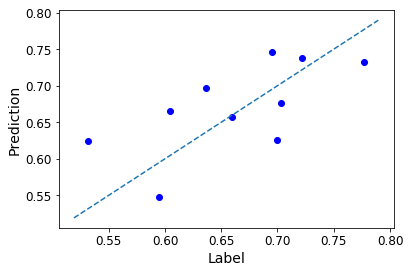

'TRAIN'


,Paclitaxel,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
75,-0.586759,-2.238355,0.406258,-1.524106,-1.656534,-1.254943,0.627497,-0.695048,-0.603999,3.237055,...,1.734082,-1.431438,0.104634,-1.396186,-1.110609,-2.923375,0.614090,-1.132275,-0.552804,-0.044824
50,-0.635358,-0.747971,0.739511,-1.284032,0.755942,0.085157,0.423303,-0.997854,-1.177830,0.661346,...,-0.295627,-0.004913,0.284697,-0.630352,0.302768,1.435265,1.634412,1.120211,0.329028,-2.156174
55,-0.527769,-1.533611,4.530134,-2.691032,0.330262,-0.020096,0.739386,1.535808,1.728431,-0.100020,...,0.258114,0.459950,-0.012614,-0.032677,0.531741,0.849622,1.087845,0.388532,-0.446362,-0.876032
38,0.215996,1.059707,0.145706,0.229752,0.198243,-0.134249,-0.206414,-0.709033,-0.633162,-0.133040,...,0.254161,0.457691,-0.157823,0.679386,0.044019,-1.852835,-1.627584,0.315598,0.825607,0.904693
10,1.080453,0.825966,0.611523,0.860288,1.071647,0.148087,0.411968,-1.115339,0.344519,0.053131,...,-0.503612,0.708535,1.115133,0.355235,0.119417,-1.069301,-1.188388,-1.553762,-0.020221,-0.573992
37,1.085602,0.895764,-0.932129,-0.753941,-0.843911,1.155658,0.428443,-0.263229,0.303081,0.170122,...,-1.311688,0.374837,0.442985,-0.028926,0.425670,0.235803,0.051552,1.924587,0.720344,-1.566430
22,1.814647,2.371833,-1.804655,-0.204060,-0.253667,2.310164,0.318231,-1.078724,-1.131702,1.815184,...,-0.303656,-1.089209,1.551954,1.380508,1.022181,0.458792,-1.040841,0.095278,-0.741186,-0.462250
18,-0.792278,-0.109440,-0.349445,-0.367019,-0.455666,-1.832773,1.432932,0.481528,0.383360,-0.753119,...,-0.620365,-0.325855,0.061336,0.061011,-0.404428,0.322519,0.340294,-0.141045,-0.206735,1.134236
57,-1.606523,0.924257,-0.825475,-2.191497,-2.624966,-0.165783,0.301296,0.459821,1.068681,0.371348,...,0.126214,-1.441477,1.258979,0.787098,0.669050,-0.453878,-0.073533,0.815106,0.940438,-0.600296
16,0.790957,-1.315922,0.346685,1.227476,1.231606,-0.405113,-0.056679,-0.168810,-1.368969,-3.270863,...,0.336177,0.621361,0.963990,0.471326,0.791117,-1.450404,-1.512635,-1.542238,-0.542485,-0.881504


'TEST'


,Paclitaxel,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
17,0.049758,-1.438241,0.311448,0.566013,0.665337,0.119503,1.820103,0.064672,-0.809383,0.409038,...,0.651434,1.049940,0.409513,0.193045,0.321072,-0.071241,0.137827,-0.260651,-1.055026,1.040164
58,0.524452,0.500491,0.527039,-1.162898,-1.384073,0.506506,1.737065,-0.165353,-0.122623,-0.002031,...,-1.459818,0.760047,0.505776,0.614423,0.403319,1.263200,1.064600,0.650655,-0.219840,-0.007697
44,-1.599238,0.469018,-0.606838,0.559511,0.417434,0.024931,-1.037619,-1.630573,-2.158573,-0.068321,...,-0.980781,-2.068947,-1.241369,-2.425960,-2.246066,-0.269772,0.025062,-0.047424,-2.745938,0.815075
3,0.241009,0.019246,1.077708,-0.165763,0.063634,0.218387,0.279202,-1.256493,-0.967278,0.964643,...,1.285229,1.241909,1.334709,1.210532,1.447161,-0.865810,-0.870251,-1.461924,0.694374,-2.103592
23,0.466167,0.724531,0.656480,1.060858,1.118257,-1.475618,0.707366,-0.576278,-1.120330,-0.390792,...,-2.264771,0.692177,0.690642,0.134304,0.543933,-0.925942,-0.969273,0.227000,-0.781739,-0.487713
26,-0.488428,-1.425359,0.216223,-0.034219,-0.029337,-1.405055,0.807951,0.365020,0.767584,0.999178,...,-0.015914,-1.790599,-2.681435,-1.106278,-0.819008,-0.549427,-0.537980,-1.143185,0.216309,-0.247637
79,-0.736072,0.005497,-0.037299,0.425832,0.237850,1.641069,-2.060183,0.875643,1.193513,0.045735,...,0.383420,0.423959,-1.939387,0.896133,0.135341,0.521166,1.073019,0.295967,-1.052520,0.888270
35,-1.084248,0.653971,-0.405100,-0.190599,-0.188093,0.174146,-0.375847,1.393828,1.728497,-0.606660,...,-0.380813,-0.051703,0.420355,0.299386,0.106821,-0.783616,-1.029316,1.824871,0.977850,-0.438806
7,-0.755067,-0.857764,0.739068,0.946397,0.990331,-2.002687,0.529223,0.143101,0.356591,-0.765658,...,1.127288,-0.274211,0.453138,-0.167983,0.045000,0.326516,0.381641,-0.016987,0.305683,-2.364792
60,-0.898478,-1.557580,-0.478653,0.818608,1.023268,0.228619,0.201260,-0.087201,0.013383,0.354514,...,0.631076,0.470099,0.848566,0.401904,0.613069,0.441770,0.542934,0.009175,-0.283711,2.053025


RMSE: 0.0819233719789
Pearson: (0.83422309922826954, 0.0026912639907538233)
Spearman: SpearmanrResult(correlation=0.86666666666666647, pvalue=0.0011735381801554687)
[ 0.6318302   0.88481254  0.54790358  0.6764573   0.76524174  0.64586205
  0.54106956  0.59029695  0.61952947  0.59279424]


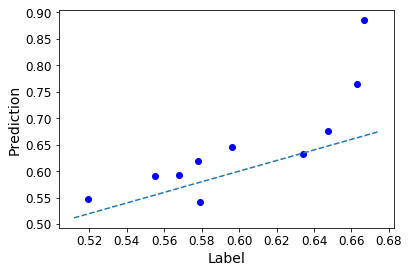

'TRAIN'


,SN-38,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
54,0.448243,0.231427,0.107238,0.297338,0.248983,-0.118577,-0.076403,-0.604826,-0.322675,-0.010206,...,0.230613,0.718364,0.684696,0.389423,0.679526,1.143307,1.200704,0.463614,0.061306,-0.227153
25,-0.412391,2.633576,0.053968,0.031015,-0.133152,-0.447004,-0.376086,0.902294,1.334467,-0.386331,...,-0.064504,0.103586,0.275093,0.248378,0.126002,-1.013299,-1.125291,-1.623489,0.566592,0.750808
2,-0.889410,0.511447,-0.697352,-0.214563,-0.270745,-1.787091,-0.128501,-0.953115,-3.017191,-0.885298,...,-0.694025,-0.097386,0.143627,-0.340637,0.182868,-0.620021,-0.562317,-1.124166,-0.078832,1.217428
10,1.402956,0.825966,0.611523,0.860288,1.071647,0.148087,0.411968,-1.115339,0.344519,0.053131,...,-0.503612,0.708535,1.115133,0.355235,0.119417,-1.069301,-1.188388,-1.553762,-0.020221,-0.573992
79,-0.312815,0.005497,-0.037299,0.425832,0.237850,1.641069,-2.060183,0.875643,1.193513,0.045735,...,0.383420,0.423959,-1.939387,0.896133,0.135341,0.521166,1.073019,0.295967,-1.052520,0.888270
6,-0.831732,-2.032552,0.615492,-0.580028,-0.221348,0.336805,-0.567045,-0.642576,-0.305474,0.572905,...,-0.153616,-0.900754,-2.928609,-2.991698,-3.119213,1.279025,1.462923,0.676311,-1.174260,-0.513722
5,-0.531059,-0.043397,0.864518,2.398056,2.772638,0.973042,-0.836989,-1.622672,-1.781000,-1.197125,...,-0.947744,-0.651192,0.014900,-0.730999,-0.213915,0.135096,0.123188,-0.373366,2.699252,1.425736
73,0.505049,-1.592838,0.197398,0.456745,0.254572,1.416631,-0.221954,-0.657534,-0.766259,-0.144746,...,0.066438,0.263903,0.661689,0.967923,0.057542,0.554401,0.601526,0.455175,-0.439074,0.604760
3,-0.636288,0.019246,1.077708,-0.165763,0.063634,0.218387,0.279202,-1.256493,-0.967278,0.964643,...,1.285229,1.241909,1.334709,1.210532,1.447161,-0.865810,-0.870251,-1.461924,0.694374,-2.103592
57,-0.555937,0.924257,-0.825475,-2.191497,-2.624966,-0.165783,0.301296,0.459821,1.068681,0.371348,...,0.126214,-1.441477,1.258979,0.787098,0.669050,-0.453878,-0.073533,0.815106,0.940438,-0.600296


'TEST'


,SN-38,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
0,-0.913739,0.588357,0.142664,0.250490,0.438791,-0.261555,-0.062797,1.487340,-0.618435,-0.344116,...,0.090808,0.481682,0.721145,0.487676,0.288662,-1.645733,-1.507012,-1.935044,1.674204,0.913093
63,-0.378281,-2.307102,0.399917,-0.142153,0.605324,0.116851,0.224335,-0.369132,-0.103637,0.215888,...,0.633367,0.900843,-0.264206,0.398105,0.530078,1.290309,1.192515,0.659735,0.562168,-0.583738
21,0.169168,0.367075,-0.262612,0.189563,0.312171,-1.704991,-0.084215,0.607700,0.810967,1.294841,...,-0.095564,-1.276399,-1.578899,-1.166881,-1.396258,0.928808,-0.725602,-0.924484,1.737940,-0.113621
19,-0.095622,0.747887,-0.244002,0.263190,0.301038,-1.834233,-0.529260,0.217260,0.421875,-0.937882,...,-0.617473,-2.006694,-0.393178,-1.828243,-1.350112,0.912771,1.108882,-0.763561,0.360804,0.047867
17,-0.729040,-1.438241,0.311448,0.566013,0.665337,0.119503,1.820103,0.064672,-0.809383,0.409038,...,0.651434,1.049940,0.409513,0.193045,0.321072,-0.071241,0.137827,-0.260651,-1.055026,1.040164
60,-0.809230,-1.557580,-0.478653,0.818608,1.023268,0.228619,0.201260,-0.087201,0.013383,0.354514,...,0.631076,0.470099,0.848566,0.401904,0.613069,0.441770,0.542934,0.009175,-0.283711,2.053025
16,1.528862,-1.315922,0.346685,1.227476,1.231606,-0.405113,-0.056679,-0.168810,-1.368969,-3.270863,...,0.336177,0.621361,0.963990,0.471326,0.791117,-1.450404,-1.512635,-1.542238,-0.542485,-0.881504
72,-0.090337,0.212782,0.679995,0.683025,0.706947,-1.985226,0.423922,-1.457280,-1.491554,-0.506736,...,-0.585960,0.006736,0.447931,-0.614340,-0.116287,0.177959,0.293198,-0.254441,1.124229,-0.718101
37,1.043987,0.895764,-0.932129,-0.753941,-0.843911,1.155658,0.428443,-0.263229,0.303081,0.170122,...,-1.311688,0.374837,0.442985,-0.028926,0.425670,0.235803,0.051552,1.924587,0.720344,-1.566430
46,-1.636065,0.122278,0.319936,0.507025,0.539322,1.721392,-2.206965,-0.264695,-0.517119,-0.076322,...,0.671794,-1.182568,-1.226783,-2.546688,-2.172926,0.715793,0.894527,0.653112,-0.278294,-1.077408


RMSE: 0.0890468109776
Pearson: (-0.043585652929277664, 0.90483730299800336)
Spearman: SpearmanrResult(correlation=-0.24848484848484845, pvalue=0.48877630451924314)
[ 0.63190983  0.67106125  0.66728324  0.65646182  0.54544626  0.59376089
  0.6171981   0.50748637  0.62966786  0.67192421]


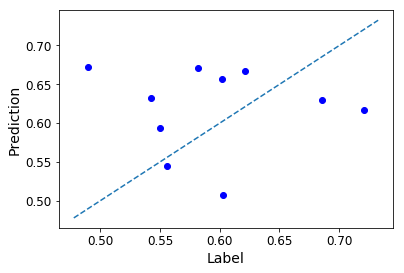

'TRAIN'


,5-FU,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
21,-0.403768,0.310121,-0.250501,0.185132,0.313935,-1.663724,-0.095148,0.588570,0.782002,1.262624,...,-0.067648,-1.275179,-1.550952,-1.172020,-1.407967,0.925370,-0.753213,-0.904795,1.738156,-0.107106
38,0.551352,1.015103,0.148341,0.224848,0.201689,-0.124978,-0.216419,-0.699782,-0.630537,-0.163107,...,0.276322,0.454450,-0.141203,0.648540,0.032904,-1.881343,-1.668201,0.349957,0.822812,0.893142
31,0.537711,0.104295,0.478300,0.613594,-1.290951,0.821187,0.164515,1.283728,1.388165,0.145238,...,-1.249385,0.754084,0.837045,1.196168,0.512116,1.247628,0.833719,0.406931,0.922738,1.032134
36,-1.157721,0.336726,-0.045521,0.253471,0.012087,1.501897,-0.740570,-0.925572,-0.722587,-0.328052,...,-1.634694,0.161704,0.092440,0.137049,0.368736,0.784372,0.507626,1.223015,0.441849,-0.819860
5,-0.753712,-0.107670,0.850471,2.367602,2.738096,0.959757,-0.842199,-1.593729,-1.753267,-1.225589,...,-0.905806,-0.651581,0.030142,-0.742207,-0.225137,0.124504,0.107816,-0.347158,2.702642,1.404942
1,-0.139740,0.700005,0.478871,0.071689,0.180758,-0.454214,-1.870746,-0.675696,0.974542,-1.198065,...,-0.080442,-0.761194,0.064330,-0.820430,-0.844696,0.029263,0.037546,-0.401302,-1.326460,0.221216
50,0.692410,-0.824806,0.728365,-1.271099,0.751159,0.089959,0.408511,-0.982379,-1.163292,0.630083,...,-0.264419,-0.006964,0.297789,-0.642962,0.291759,1.436391,1.640831,1.164088,0.324594,-2.113423
58,0.930413,0.445916,0.520824,-1.151392,-1.357279,0.502725,1.712284,-0.167821,-0.131166,-0.032295,...,-1.409454,0.756028,0.517105,0.584482,0.392352,1.262775,1.062803,0.688977,-0.226086,-0.003061
25,-0.164457,2.617034,0.058731,0.028452,-0.124817,-0.431362,-0.384801,0.876816,1.294051,-0.416016,...,-0.037099,0.101256,0.288261,0.223533,0.114921,-1.034241,-1.158665,-1.612068,0.562942,0.741987
22,1.910439,2.350625,-1.756758,-0.203852,-0.243553,2.269643,0.304238,-1.061505,-1.118172,1.782183,...,-0.272316,-1.088471,1.554944,1.339900,1.011469,0.451118,-1.072998,0.127030,-0.749154,-0.449550


'TEST'


,5-FU,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
80,0.631374,0.131859,0.091329,0.321020,0.413532,-0.253189,-0.012295,2.780437,-0.440756,1.532764,...,0.378156,0.490852,0.752985,0.179089,0.441809,-1.318490,-1.530349,0.535215,-0.343869,0.627593
34,-2.306724,0.894221,0.168317,1.203987,-1.483335,0.542285,-1.194863,1.063210,1.154942,0.037077,...,-1.487900,0.660644,0.761541,-0.198848,0.684666,-0.327399,-0.417020,0.379794,0.383599,1.054934
71,-0.135891,-0.152369,-1.781084,0.090195,-0.058149,-1.509194,-0.505980,0.252019,0.540367,1.695461,...,-0.170539,1.635147,-0.974688,1.099326,1.231262,0.587018,0.748959,0.254995,0.271207,-0.156317
41,0.599890,-0.242223,-0.149332,-1.336018,0.142627,0.919895,0.578833,0.628545,0.574580,-0.726437,...,0.713609,-0.640257,-0.129563,-0.021098,0.257333,0.976413,1.170592,0.268629,-1.999381,-0.283206
57,-1.637267,0.877238,-0.800302,-2.167871,-2.579861,-0.155870,0.287431,0.443879,1.034079,0.340522,...,0.150481,-1.439832,1.264304,0.754752,0.658193,-0.469777,-0.091742,0.855373,0.938021,-0.585148
42,1.679347,-0.268746,-0.202040,1.356366,1.562572,0.511687,-0.575607,0.404432,0.717856,-1.954565,...,0.279373,0.281714,-1.627715,0.540827,-0.084425,-0.606428,-0.702307,1.460726,0.233253,-0.441574
29,1.075899,0.004170,-1.449105,-0.554319,-0.999019,-0.150043,3.534679,0.301814,0.797556,0.224429,...,-2.812122,0.647684,0.171950,0.390516,0.441990,0.300345,0.062674,1.401884,0.322455,0.896720
6,-0.400441,-2.132292,0.607224,-0.575391,-0.211711,0.336481,-0.574307,-0.634757,-0.310018,0.541775,...,-0.124744,-0.900500,-2.889903,-2.971429,-3.131632,1.278743,1.466869,0.714936,-1.183658,-0.500110
54,1.002861,0.172055,0.110766,0.291637,0.251680,-0.109625,-0.087395,-0.597822,-0.326842,-0.040458,...,0.253162,0.714452,0.694599,0.362615,0.668673,1.141801,1.200869,0.499724,0.055988,-0.218624


RMSE: 0.137537155109
Pearson: (-0.056797586660395076, 0.88460351115120872)
Spearman: SpearmanrResult(correlation=-0.033333333333333333, pvalue=0.93215673554050393)
[ 0.88015643  0.83233762  0.8061477   0.83084752  0.87739904  0.84835716
  0.73109773  0.6361456   0.81715214]


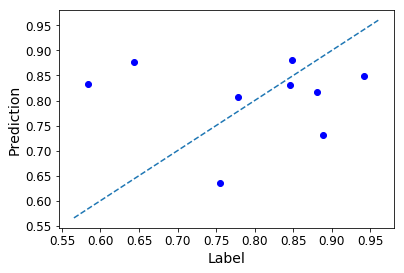

'TRAIN'


,Oxaliplatin,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
32,1.303570,0.985376,0.068939,0.516019,-1.470482,0.720290,-1.258015,1.246579,1.341709,0.021918,...,-1.439200,0.725644,0.979701,0.544713,0.785271,-0.440465,-0.386701,0.458173,0.766543,1.098605
3,-0.169125,0.005590,1.057795,-0.144301,-0.010176,0.233896,0.260440,-1.213215,-0.935777,0.995470,...,1.280414,1.248070,1.330488,1.168589,1.455707,-0.834649,-0.842467,-1.417129,0.697898,-2.044377
76,-1.215699,0.855661,0.154547,-0.008592,-0.149816,-0.585222,-0.304303,-3.179076,-0.824441,-0.309643,...,0.048793,0.311381,0.182725,0.300210,0.411422,-1.660034,-1.817235,-2.135968,-0.948507,0.823401
4,-0.481321,0.145837,0.288712,0.335308,0.112231,-0.291450,-0.162962,-0.481702,-0.636917,-0.167535,...,0.259453,2.464496,0.688095,2.155625,2.151633,0.850275,-1.168437,0.440399,0.699286,-0.955804
17,-0.667248,-1.443405,0.315270,0.582339,0.628385,0.137675,1.800302,0.079290,-0.781030,0.425934,...,0.649975,1.057084,0.405417,0.172561,0.329624,-0.044268,0.164463,-0.238287,-1.146789,1.031900
63,-2.048532,-2.307204,0.400999,-0.120856,0.564696,0.135095,0.205610,-0.345103,-0.089357,0.227940,...,0.632004,0.908750,-0.268210,0.373296,0.538629,1.310107,1.217949,0.664912,0.558491,-0.557145
38,-0.958851,1.039989,0.154662,0.248438,0.132679,-0.109241,-0.224849,-0.677630,-0.608323,-0.129737,...,0.254805,0.467867,-0.161842,0.648645,0.052573,-1.816471,-1.598938,0.327202,0.836279,0.899337
75,-0.992285,-2.238858,0.407144,-1.493111,-1.835716,-1.199747,0.608500,-0.663949,-0.579741,3.324862,...,1.726890,-1.411590,0.100580,-1.383152,-1.102048,-2.881369,0.640184,-1.093634,-0.617213,-0.029799
31,0.381943,0.150350,0.481998,0.639059,-1.475120,0.830581,0.158745,1.305596,1.414372,0.186816,...,-1.288212,0.766736,0.824134,1.192293,0.531584,1.268208,0.864610,0.382458,0.941301,1.037802
80,-0.013502,0.177273,0.098104,0.345074,0.360866,-0.236592,-0.019300,2.802092,-0.418166,1.611279,...,0.357794,0.504176,0.739410,0.182606,0.461306,-1.261586,-1.463201,0.506875,-0.389902,0.634795


'TEST'


,Oxaliplatin,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
36,-1.307474,0.377379,-0.037657,0.277200,-0.071551,1.506728,-0.752660,-0.903388,-0.700554,-0.299073,...,-1.677893,0.175869,0.073647,0.140871,0.388265,0.811510,0.543519,1.173940,0.435888,-0.807171
10,-0.496244,0.807610,0.606051,0.874548,1.059585,0.165490,0.393117,-1.075122,0.349863,0.061102,...,-0.498955,0.717427,1.110942,0.331331,0.127970,-1.037067,-1.160242,-1.507252,-0.055620,-0.547608
21,-0.738481,0.351393,-0.241008,0.208531,0.253585,-1.637672,-0.102732,0.610538,0.807010,1.333948,...,-0.093067,-1.257345,-1.582725,-1.158684,-1.387696,0.950511,-0.697983,-0.889724,1.798306,-0.097119
78,0.264888,0.303763,0.546087,0.988388,-0.744277,0.645803,-1.627971,0.278176,0.362142,0.185004,...,-1.181451,0.958636,0.061022,0.605969,0.516991,-0.935061,-0.980007,-1.327916,-0.275264,-0.431823
55,1.704766,-1.538219,4.403284,-2.651845,0.272785,0.001837,0.720314,1.518513,1.706181,-0.095889,...,0.258738,0.470115,-0.016653,-0.048401,0.540291,0.871743,1.113399,0.398774,-0.504972,-0.843166
62,0.948432,-0.309090,0.468313,0.911727,0.962909,-0.827347,0.404794,0.525834,0.326124,-1.085282,...,1.097234,-0.624426,-0.993565,0.258570,-0.258509,0.004128,0.158627,-0.446817,1.233021,0.639573
56,0.851415,0.350157,0.148811,0.613370,0.563790,-0.316543,2.335389,1.487161,1.702675,2.047501,...,0.566620,0.703822,0.634428,0.241625,1.046134,-1.461867,-1.454715,-1.632330,-0.462803,-0.804268
44,-0.918518,0.452742,-0.574572,0.575883,0.365296,0.045652,-1.055493,-1.579180,-2.103317,-0.063396,...,-0.973597,-2.045835,-1.245242,-2.391209,-2.237499,-0.241752,0.051826,-0.029042,-2.929804,0.811643
24,-0.685042,0.967917,1.013907,-0.138761,-0.533588,1.254090,-0.693241,2.191803,0.502352,0.892988,...,0.107311,-1.883445,-1.164726,-2.454882,-2.020243,0.380548,0.626434,-1.625944,0.740979,3.193909


RMSE: 0.162000082266
Pearson: (-0.16347390588020891, 0.67430120822689132)
Spearman: SpearmanrResult(correlation=0.099999999999999992, pvalue=0.79797169523485101)
[ 0.79574957  1.0570359   1.00190962  1.03730815  0.80244047  1.02508022
  0.70787268  0.85467778  0.9360883 ]


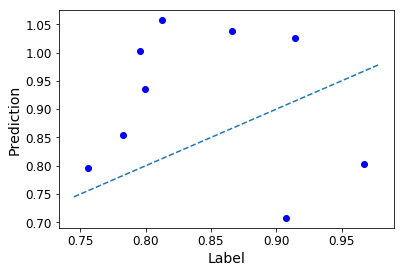

In [160]:
for label in labels:
    modelPipeline, labelPipeline, featureSetPipeline  = retrieve_pipelines("ridge_model", Ridge(alpha = 0.5))
    
    # Impute samples where label is NA
    X_nonNA, y_nonNA = remove_NAs(X, y, label)
    
    X_nonNA_tr = featureSetPipeline.fit_transform(X_nonNA)
    y_nonNA_tr = labelPipeline.fit_transform(y_nonNA)
    
    X_nonNA_tr = pd.DataFrame(data=X_nonNA_tr, index=X_nonNA.index.values, columns = X_nonNA.columns.values)
    y_nonNA_tr = pd.DataFrame(data=y_nonNA_tr, index=y_nonNA.index.values, columns = y_nonNA.columns.values)
    
    X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X_nonNA_tr, y_nonNA_tr, test_size=0.15)
    
    
    display_set(X_TRAIN, X_TEST, Y_TRAIN, Y_TEST)

    y_test_np, y_prediction, this_y_train_tr = train_and_test(labelPipeline, XYpipeline, X_TRAIN, X_TEST, Y_TRAIN.values, Y_TEST.values)

    rmse, r, t = simple_score(y_test_np, y_prediction)
    
    print("RMSE: " + str(rmse))
    print("Pearson: " + str(r))
    print("Spearman: " + str(t))

    #scores = cv_score(XYpipeline, X_TRAIN, this_y_train_tr)
    
    #print("CV Scores: " + str(scores))
    #print("CV Mean: " + str(scores.mean()))
    #print("CV STD: " + str(scores.std()))
    print(y_prediction)
    visualize(y_test_np, y_prediction)


### Visualize ML results using Random Forest Regressor

'TRAIN'


,Gemcitabine,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
17,0.620575,-0.643871,0.275013,0.194772,0.369137,-0.666809,0.834148,0.196153,0.067816,0.419021,...,0.243152,0.131670,0.112095,-0.214004,0.104169,-0.332905,-0.295921,-0.312050,-0.154407,-0.003312
60,0.636072,-0.707466,0.013022,0.275942,0.468375,-0.614229,0.163729,0.151776,0.267469,0.402895,...,0.237640,-0.023628,0.384223,-0.131184,0.219540,-0.136251,-0.156745,-0.208665,0.165950,0.520566
75,0.547590,-1.070249,0.306451,-0.476875,-0.274606,-1.329115,0.340248,-0.025836,0.117655,1.255420,...,0.536290,-0.532914,-0.076870,-0.844192,-0.461503,-1.426220,-0.132299,-0.646015,0.054185,-0.564496
3,0.677571,0.132817,0.529099,-0.040379,0.202314,-0.619159,0.196007,-0.189890,0.029501,0.583344,...,0.414758,0.183085,0.685537,0.189467,0.549099,-0.637489,-0.642251,-0.772321,0.572187,-1.629346
72,0.592928,0.235951,0.397220,0.232373,0.380674,-1.681018,0.255941,-0.248559,-0.097720,0.148177,...,-0.091886,-0.147730,0.135907,-0.534161,-0.068636,-0.237379,-0.242543,-0.309670,0.750722,-0.912733
53,0.736810,-0.311980,0.188978,-0.328543,-0.023405,-0.415048,-0.435632,0.138366,0.179719,-0.193154,...,0.220613,-0.518884,-0.600909,-0.739336,-0.651961,-0.517926,-0.554708,-0.503599,0.850619,-0.633129
32,0.736595,0.658000,0.190721,0.173310,-0.179189,-0.378291,-0.433262,0.544796,0.593400,0.302455,...,-0.325525,0.042444,0.468088,-0.063252,0.284201,-0.485585,-0.485492,-0.040121,0.599225,0.031946
35,0.594934,0.471059,0.037412,-0.048361,0.132522,-0.640478,-0.075271,0.584531,0.683658,0.118624,...,-0.036340,-0.163381,0.118815,-0.171836,0.019516,-0.605981,-0.696899,0.487024,0.689926,-0.768274
36,0.703385,0.332102,0.154244,0.096025,0.186280,0.011162,-0.223836,-0.097351,0.087742,0.209842,...,-0.390498,-0.105559,-0.093565,-0.226841,0.127339,-0.003120,-0.165546,0.239346,0.468985,-0.975393
63,0.628506,-1.106883,0.304349,-0.032793,0.352499,-0.668086,0.173285,0.069396,0.239072,0.361896,...,0.238260,0.091738,-0.305479,-0.132690,0.186750,0.189021,0.066422,0.040599,0.517277,-0.843237


'TEST'


,Gemcitabine,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
7,0.557171,-0.334538,0.416808,0.317006,0.459243,-1.689432,0.299550,0.219070,0.350752,0.071599,...,0.371994,-0.222975,0.139134,-0.357164,-0.004910,-0.180432,-0.212158,-0.218690,0.410748,-1.764445
79,0.726312,0.125490,0.159371,0.149726,0.250616,0.066391,-0.772814,0.433117,0.553839,0.311573,...,0.170584,-0.035985,-1.343767,0.064796,0.030785,-0.105816,0.025369,-0.098780,-0.153367,-0.081876
16,0.646874,-0.578688,0.286697,0.407330,0.526137,-0.919606,0.056907,0.127930,-0.067973,-0.669326,...,0.157793,0.016885,0.455764,-0.103655,0.289889,-0.861582,-0.862945,-0.803094,0.058471,-0.997249
2,0.610292,0.395108,-0.059497,-0.056061,0.109607,-1.585542,0.027163,-0.101243,-0.467931,0.036215,...,-0.121145,-0.175617,-0.052702,-0.425628,0.049563,-0.543270,-0.536459,-0.642908,0.251044,0.088374
33,0.672706,0.583449,0.266560,0.205795,-0.216464,-0.590275,0.124106,0.518899,0.562426,0.020219,...,-0.351980,0.013492,0.150896,0.045354,0.190954,-0.001475,-0.010121,-0.024547,0.226152,0.019438
4,0.694529,0.207992,0.265925,0.114829,0.234293,-0.879316,0.020543,0.028597,0.103498,0.247794,...,0.136851,0.510556,0.287325,0.589296,0.824069,0.011819,-0.754368,-0.047061,0.572734,-1.053957
19,0.680200,0.521106,0.090831,0.097462,0.268135,-1.608259,-0.138805,0.240739,0.366593,0.020663,...,-0.100418,-0.686984,-0.385417,-1.015519,-0.556133,0.044298,0.037689,-0.504741,0.433642,-0.516554
50,0.587329,-0.276030,0.416955,-0.399729,0.394258,-0.683359,0.255684,-0.114316,-0.021591,0.493642,...,-0.013275,-0.150850,0.034734,-0.540511,0.096937,0.244587,0.218238,0.217032,0.420445,-1.656542
55,0.595509,-0.694693,1.673895,-0.851859,0.276237,-0.734077,0.386585,0.626017,0.683642,0.268465,...,0.136656,-0.026346,-0.149542,-0.303511,0.187407,0.020091,0.030462,-0.063313,0.098395,-0.994419
62,0.626015,-0.035858,0.327383,0.301367,0.456532,-1.144699,0.255829,0.329526,0.341944,-0.016995,...,0.364896,-0.321004,-0.755120,-0.179163,-0.128210,-0.314255,-0.297928,-0.393469,0.782964,-0.210686


c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


RMSE: 0.0502286984138
Pearson: (0.24735069058647921, 0.49082735034125069)
Spearman: SpearmanrResult(correlation=0.34545454545454546, pvalue=0.32822651147136733)


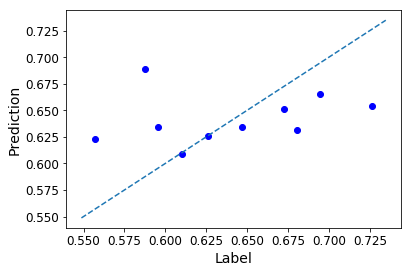

'TRAIN'


,Paclitaxel,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
54,0.659587,0.245887,0.207299,0.108435,0.253702,-0.781532,0.048739,0.000527,0.185921,0.295028,...,0.129210,0.042865,0.282655,-0.136132,0.245798,0.132670,0.069235,-0.034546,0.309249,-0.658802
80,0.565054,0.224842,0.200701,0.117990,0.299248,-0.852150,0.080079,1.009393,0.157660,0.761017,...,0.163620,-0.017176,0.319134,-0.209935,0.156199,-0.802015,-0.855750,-0.021106,0.143719,-0.213211
23,0.662895,0.508660,0.389423,0.353788,0.494711,-1.435452,0.373325,0.008868,-0.007638,0.182468,...,-0.546441,0.035851,0.286341,-0.237297,0.192224,-0.660539,-0.676271,-0.125205,-0.040901,-0.793571
25,0.592818,1.525981,0.189635,0.022854,0.147755,-0.939792,-0.075371,0.440905,0.588043,0.183787,...,0.049304,-0.121791,0.028781,-0.192062,0.027095,-0.694026,-0.729871,-0.834225,0.519114,-0.152975
31,0.667870,0.210411,0.332066,0.213128,-0.180401,-0.323674,0.153863,0.562423,0.611391,0.350031,...,-0.284426,0.053507,0.371654,0.199069,0.183966,0.172875,-0.055108,-0.069684,0.668060,-0.000193
19,0.577722,0.521106,0.090831,0.097462,0.268135,-1.608259,-0.138805,0.240739,0.366593,0.020663,...,-0.100418,-0.686984,-0.385417,-1.015519,-0.556133,0.044298,0.037689,-0.504741,0.433642,-0.516554
78,0.745540,0.292643,0.353997,0.326176,0.010531,-0.415178,-0.586578,0.255556,0.350862,0.349508,...,-0.255366,0.105168,-0.101392,-0.038439,0.178200,-0.676184,-0.689558,-0.737489,0.188873,-0.776995
58,0.666951,0.389270,0.346501,-0.360803,-0.199066,-0.480322,0.799759,0.128940,0.234465,0.297446,...,-0.328492,0.054029,0.171760,-0.046912,0.136666,0.178629,0.022476,0.037120,0.192478,-0.545293
5,0.546421,0.099434,0.458407,0.783488,0.953391,-0.255512,-0.266247,-0.296886,-0.167956,-0.056009,...,-0.189842,-0.323942,-0.132488,-0.580421,-0.107210,-0.253809,-0.300951,-0.355237,1.404891,0.196116
34,0.614227,0.623985,0.226836,0.405109,-0.234539,-0.460864,-0.413416,0.496569,0.553532,0.317994,...,-0.350087,0.028416,0.324480,-0.361917,0.252115,-0.425491,-0.478697,-0.079960,0.444871,0.011813


'TEST'


,Paclitaxel,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
45,0.681017,0.408618,0.239970,0.132204,0.329395,-0.872063,-0.023006,0.064081,0.159717,0.347745,...,0.184621,0.030339,0.395140,0.070150,0.343680,-0.832694,-0.887840,0.060472,0.128659,-0.819656
72,0.741068,0.235951,0.397220,0.232373,0.380674,-1.681018,0.255941,-0.248559,-0.097720,0.148177,...,-0.091886,-0.147730,0.135907,-0.534161,-0.068636,-0.237379,-0.242543,-0.309670,0.750722,-0.912733
30,0.652945,-0.109660,-0.007023,-0.205337,0.104510,-0.689720,0.251075,0.050076,0.281951,0.103067,...,0.537130,-0.229109,-1.315222,-0.590476,-0.181312,-0.203817,-0.208228,-0.255898,0.576892,-0.807384
35,0.555007,0.471059,0.037412,-0.048361,0.132522,-0.640478,-0.075271,0.584531,0.683658,0.118624,...,-0.036340,-0.163381,0.118815,-0.171836,0.019516,-0.605981,-0.696899,0.487024,0.689926,-0.768274
6,0.566868,-0.960577,0.375832,-0.173501,0.123302,-0.562097,-0.154453,-0.010504,0.190095,0.467486,...,0.025176,-0.390782,-1.956893,-1.476872,-1.255124,0.184695,0.159322,0.046950,-0.203930,-0.807023
53,0.685397,-0.311980,0.188978,-0.328543,-0.023405,-0.415048,-0.435632,0.138366,0.179719,-0.193154,...,0.220613,-0.518884,-0.600909,-0.739336,-0.651961,-0.517926,-0.554708,-0.503599,0.850619,-0.633129
26,0.596468,-0.637006,0.243437,0.001891,0.176538,-1.401450,0.414980,0.283914,0.450483,0.593558,...,0.062460,-0.629108,-1.803693,-0.729233,-0.346289,-0.516209,-0.528098,-0.650195,0.373628,-0.669397
61,0.826007,0.457804,-0.564891,0.228308,0.303327,-0.691149,-0.535123,0.101311,0.207659,0.584738,...,0.392570,-0.779931,-0.824033,-0.749541,-0.737905,0.170624,0.127514,0.026419,0.217194,-0.828724
44,0.519171,0.372498,-0.029483,0.192683,0.300406,-0.712380,-0.349334,-0.299195,-0.259578,0.277840,...,-0.198787,-0.703658,-0.911131,-1.252536,-0.910134,-0.409008,-0.334662,-0.230351,-0.856709,-0.119734
0,0.715357,0.436093,0.219046,0.093381,0.306327,-0.850429,0.054373,0.611854,0.114151,0.196272,...,0.091356,-0.020526,0.305247,-0.097172,0.091364,-0.936458,-0.861014,-0.953599,0.979149,-0.069036


c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


RMSE: 0.101450431027
Pearson: (0.059213633617916053, 0.87092338632316568)
Spearman: SpearmanrResult(correlation=-0.0303030303030303, pvalue=0.93377295809414662)


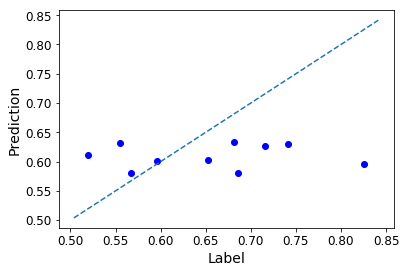

'TRAIN'


,SN-38,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
14,0.549305,0.311621,0.310739,-0.866207,-0.654559,0.180585,0.050780,0.022852,0.116973,0.285787,...,0.127948,-0.031667,0.262835,0.065896,0.028427,0.067152,-0.008213,-0.050196,-0.032852,-0.068656
59,0.554903,-0.724552,0.145695,0.129056,0.319179,-0.877704,0.016272,0.025682,0.158200,0.272115,...,0.134199,0.008095,0.221459,-0.333862,0.090087,-0.854928,-0.906549,0.466643,0.024067,-0.115916
37,0.685489,0.599909,-0.137347,-0.229387,-0.049305,-0.167514,0.257813,0.100341,0.337767,0.348361,...,-0.288384,-0.049142,0.132842,-0.302024,0.145497,-0.215205,-0.325561,0.525230,0.582973,-1.351511
26,0.655725,-0.637006,0.243437,0.001891,0.176538,-1.401450,0.414980,0.283914,0.450483,0.593558,...,0.062460,-0.629108,-1.803693,-0.729233,-0.346289,-0.516209,-0.528098,-0.650195,0.373628,-0.669397
3,0.562632,0.132817,0.529099,-0.040379,0.202314,-0.619159,0.196007,-0.189890,0.029501,0.583344,...,0.414758,0.183085,0.685537,0.189467,0.549099,-0.637489,-0.642251,-0.772321,0.572187,-1.629346
73,0.646083,-0.726256,0.237195,0.159660,0.255252,-0.041759,-0.011539,-0.014875,0.078281,0.255237,...,0.084758,-0.078853,0.268396,0.093264,0.000046,-0.093076,-0.136615,-0.037779,0.101421,-0.228514
45,0.735381,0.408618,0.239970,0.132204,0.329395,-0.872063,-0.023006,0.064081,0.159717,0.347745,...,0.184621,0.030339,0.395140,0.070150,0.343680,-0.832694,-0.887840,0.060472,0.128659,-0.819656
38,0.632628,0.687273,0.220055,0.086717,0.239635,-0.789084,-0.005104,-0.029922,0.110578,0.258699,...,0.135586,-0.026951,-0.239543,-0.021152,-0.005297,-1.015847,-0.902437,-0.091258,0.626693,-0.073381
21,0.621525,0.318173,0.084660,0.073802,0.271221,-1.545981,0.045503,0.354825,0.461010,0.681002,...,0.040894,-0.491390,-1.120334,-0.753265,-0.574366,0.050446,-0.592556,-0.566400,1.005621,-0.600080
31,0.563638,0.210411,0.332066,0.213128,-0.180401,-0.323674,0.153863,0.562423,0.611391,0.350031,...,-0.284426,0.053507,0.371654,0.199069,0.183966,0.172875,-0.055108,-0.069684,0.668060,-0.000193


'TEST'


,SN-38,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
28,0.600012,0.314449,0.237437,0.159986,-0.544854,-0.716516,0.348593,0.090180,0.208602,0.892201,...,0.154605,0.058315,-0.956257,-0.140692,0.270730,0.124166,0.106010,0.046427,-0.785716,-0.377682
44,0.564607,0.372498,-0.029483,0.192683,0.300406,-0.712380,-0.349334,-0.299195,-0.259578,0.277840,...,-0.198787,-0.703658,-0.911131,-1.252536,-0.910134,-0.409008,-0.334662,-0.230351,-0.856709,-0.119734
6,0.548342,-0.960577,0.375832,-0.173501,0.123302,-0.562097,-0.154453,-0.010504,0.190095,0.467486,...,0.025176,-0.390782,-1.956893,-1.476872,-1.255124,0.184695,0.159322,0.046950,-0.203930,-0.807023
23,0.491755,0.508660,0.389423,0.353788,0.494711,-1.435452,0.373325,0.008868,-0.007638,0.182468,...,-0.546441,0.035851,0.286341,-0.237297,0.192224,-0.660539,-0.676271,-0.125205,-0.040901,-0.793571
29,0.679164,0.157990,-0.322231,-0.166649,-0.098250,-0.801414,1.560258,0.269189,0.464869,0.373487,...,-0.714632,0.024936,-0.043888,-0.124913,0.156270,-0.187006,-0.316239,0.307079,0.419559,-0.071497
75,0.537030,-1.070249,0.306451,-0.476875,-0.274606,-1.329115,0.340248,-0.025836,0.117655,1.255420,...,0.536290,-0.532914,-0.076870,-0.844192,-0.461503,-1.426220,-0.132299,-0.646015,0.054185,-0.564496
22,0.877780,1.386500,-0.426669,-0.052686,0.114342,0.388810,0.212170,-0.137946,-0.010398,0.834895,...,-0.015449,-0.441255,0.820187,0.256869,0.381185,-0.129726,-0.700858,-0.175675,-0.024058,-0.780400
78,0.701093,0.292643,0.353997,0.326176,0.010531,-0.415178,-0.586578,0.255556,0.350862,0.349508,...,-0.255366,0.105168,-0.101392,-0.038439,0.178200,-0.676184,-0.689558,-0.737489,0.188873,-0.776995
36,0.622144,0.332102,0.154244,0.096025,0.186280,0.011162,-0.223836,-0.097351,0.087742,0.209842,...,-0.390498,-0.105559,-0.093565,-0.226841,0.127339,-0.003120,-0.165546,0.239346,0.468985,-0.975393
16,0.720942,-0.578688,0.286697,0.407330,0.526137,-0.919606,0.056907,0.127930,-0.067973,-0.669326,...,0.157793,0.016885,0.455764,-0.103655,0.289889,-0.861582,-0.862945,-0.803094,0.058471,-0.997249


c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


RMSE: 0.108373005358
Pearson: (0.13561835712278111, 0.70873126033510625)
Spearman: SpearmanrResult(correlation=0.41818181818181815, pvalue=0.22911284098281892)


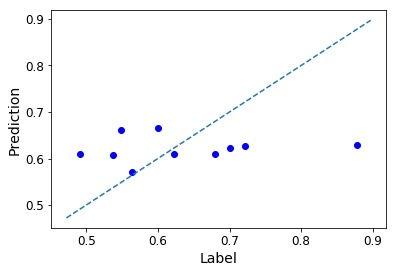

'TRAIN'


,5-FU,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
63,0.696855,-1.106883,0.304349,-0.032793,0.352499,-0.668086,0.173285,0.069396,0.239072,0.361896,...,0.238260,0.091738,-0.305479,-0.132690,0.186750,0.189021,0.066422,0.040599,0.517277,-0.843237
62,0.794304,-0.035858,0.327383,0.301367,0.456532,-1.144699,0.255829,0.329526,0.341944,-0.016995,...,0.364896,-0.321004,-0.755120,-0.179163,-0.128210,-0.314255,-0.297928,-0.393469,0.782964,-0.210686
76,0.778166,0.588470,0.220015,0.003538,0.165833,-1.024796,-0.038030,-0.777049,0.057068,0.206793,...,0.079509,-0.069078,-0.025949,-0.162296,0.136489,-0.955562,-0.977519,-1.052988,-0.076307,-0.113519
42,0.942370,0.015101,0.101111,0.454659,0.622593,-0.475914,-0.154996,0.299835,0.445097,-0.271932,...,0.136426,-0.073334,-1.168295,-0.064467,-0.051636,-0.531497,-0.575316,0.329361,0.382632,-0.776200
34,0.583491,0.623985,0.226836,0.405109,-0.234539,-0.460864,-0.413416,0.496569,0.553532,0.317994,...,-0.350087,0.028416,0.324480,-0.361917,0.252115,-0.425491,-0.478697,-0.079960,0.444871,0.011813
32,0.909020,0.658000,0.190721,0.173310,-0.179189,-0.378291,-0.433262,0.544796,0.593400,0.302455,...,-0.325525,0.042444,0.468088,-0.063252,0.284201,-0.485585,-0.485492,-0.040121,0.599225,0.031946
10,0.800295,0.562714,0.374516,0.289336,0.481788,-0.653035,0.250990,-0.148644,0.347822,0.313760,...,-0.069589,0.040232,0.549443,-0.149689,0.024493,-0.715494,-0.751549,-0.807509,0.275388,-0.838196
14,0.831634,0.311621,0.310739,-0.866207,-0.654559,0.180585,0.050780,0.022852,0.116973,0.285787,...,0.127948,-0.031667,0.262835,0.065896,0.028427,0.067152,-0.008213,-0.050196,-0.032852,-0.068656
29,0.888039,0.157990,-0.322231,-0.166649,-0.098250,-0.801414,1.560258,0.269189,0.464869,0.373487,...,-0.714632,0.024936,-0.043888,-0.124913,0.156270,-0.187006,-0.316239,0.307079,0.419559,-0.071497
46,0.726636,0.187722,0.277828,0.175817,0.334200,0.105097,-0.833601,0.099912,0.138737,0.275474,...,0.248664,-0.466260,-0.902091,-1.300409,-0.881236,-0.031210,-0.035953,0.038061,0.168200,-1.098576


'TEST'


,5-FU,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
60,0.762266,-0.707466,0.013022,0.275942,0.468375,-0.614229,0.163729,0.151776,0.267469,0.402895,...,0.237640,-0.023628,0.384223,-0.131184,0.219540,-0.136251,-0.156745,-0.208665,0.165950,0.520566
31,0.839585,0.210411,0.332066,0.213128,-0.180401,-0.323674,0.153863,0.562423,0.611391,0.350031,...,-0.284426,0.053507,0.371654,0.199069,0.183966,0.172875,-0.055108,-0.069684,0.668060,-0.000193
45,0.958466,0.408618,0.239970,0.132204,0.329395,-0.872063,-0.023006,0.064081,0.159717,0.347745,...,0.184621,0.030339,0.395140,0.070150,0.343680,-0.832694,-0.887840,0.060472,0.128659,-0.819656
22,0.963176,1.386500,-0.426669,-0.052686,0.114342,0.388810,0.212170,-0.137946,-0.010398,0.834895,...,-0.015449,-0.441255,0.820187,0.256869,0.381185,-0.129726,-0.700858,-0.175675,-0.024058,-0.780400
79,0.739124,0.125490,0.159371,0.149726,0.250616,0.066391,-0.772814,0.433117,0.553839,0.311573,...,0.170584,-0.035985,-1.343767,0.064796,0.030785,-0.105816,0.025369,-0.098780,-0.153367,-0.081876
35,0.655291,0.471059,0.037412,-0.048361,0.132522,-0.640478,-0.075271,0.584531,0.683658,0.118624,...,-0.036340,-0.163381,0.118815,-0.171836,0.019516,-0.605981,-0.696899,0.487024,0.689926,-0.768274
72,0.621484,0.235951,0.397220,0.232373,0.380674,-1.681018,0.255941,-0.248559,-0.097720,0.148177,...,-0.091886,-0.147730,0.135907,-0.534161,-0.068636,-0.237379,-0.242543,-0.309670,0.750722,-0.912733
61,0.875244,0.457804,-0.564891,0.228308,0.303327,-0.691149,-0.535123,0.101311,0.207659,0.584738,...,0.392570,-0.779931,-0.824033,-0.749541,-0.737905,0.170624,0.127514,0.026419,0.217194,-0.828724
6,0.755120,-0.960577,0.375832,-0.173501,0.123302,-0.562097,-0.154453,-0.010504,0.190095,0.467486,...,0.025176,-0.390782,-1.956893,-1.476872,-1.255124,0.184695,0.159322,0.046950,-0.203930,-0.807023


c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


RMSE: 0.102828322408
Pearson: (0.80159368294211597, 0.0093776959954245294)
Spearman: SpearmanrResult(correlation=0.76666666666666672, pvalue=0.015944016578974009)


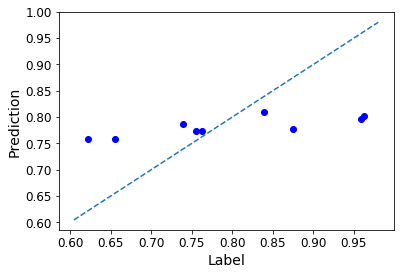

'TRAIN'


,Oxaliplatin,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
19,0.854693,0.521106,0.090831,0.097462,0.268135,-1.608259,-0.138805,0.240739,0.366593,0.020663,...,-0.100418,-0.686984,-0.385417,-1.015519,-0.556133,0.044298,0.037689,-0.504741,0.433642,-0.516554
7,0.914860,-0.334538,0.416808,0.317006,0.459243,-1.689432,0.299550,0.219070,0.350752,0.071599,...,0.371994,-0.222975,0.139134,-0.357164,-0.004910,-0.180432,-0.212158,-0.218690,0.410748,-1.764445
37,0.858955,0.599909,-0.137347,-0.229387,-0.049305,-0.167514,0.257813,0.100341,0.337767,0.348361,...,-0.288384,-0.049142,0.132842,-0.302024,0.145497,-0.215205,-0.325561,0.525230,0.582973,-1.351511
84,0.823390,0.209831,-0.808317,-0.750588,0.358634,-0.961758,0.770711,0.360627,0.146476,0.012686,...,0.264957,-0.054121,0.497045,-0.356345,-0.119807,-0.012674,-0.037067,0.052281,0.799718,-0.999914
10,0.812751,0.562714,0.374516,0.289336,0.481788,-0.653035,0.250990,-0.148644,0.347822,0.313760,...,-0.069589,0.040232,0.549443,-0.149689,0.024493,-0.715494,-0.751549,-0.807509,0.275388,-0.838196
33,0.924407,0.583449,0.266560,0.205795,-0.216464,-0.590275,0.124106,0.518899,0.562426,0.020219,...,-0.351980,0.013492,0.150896,0.045354,0.190954,-0.001475,-0.010121,-0.024547,0.226152,0.019438
46,0.746754,0.187722,0.277828,0.175817,0.334200,0.105097,-0.833601,0.099912,0.138737,0.275474,...,0.248664,-0.466260,-0.902091,-1.300409,-0.881236,-0.031210,-0.035953,0.038061,0.168200,-1.098576
17,0.800729,-0.643871,0.275013,0.194772,0.369137,-0.666809,0.834148,0.196153,0.067816,0.419021,...,0.243152,0.131670,0.112095,-0.214004,0.104169,-0.332905,-0.295921,-0.312050,-0.154407,-0.003312
62,0.914314,-0.035858,0.327383,0.301367,0.456532,-1.144699,0.255829,0.329526,0.341944,-0.016995,...,0.364896,-0.321004,-0.755120,-0.179163,-0.128210,-0.314255,-0.297928,-0.393469,0.782964,-0.210686
40,0.862368,-0.664004,0.084070,0.011042,0.226630,-0.792907,0.028922,0.260095,0.329526,0.255372,...,0.163944,-0.013698,-0.110968,-0.121455,0.089076,-0.854566,-0.942120,-1.006756,0.121167,-0.563011


'TEST'


,Oxaliplatin,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
35,0.797361,0.471059,0.037412,-0.048361,0.132522,-0.640478,-0.075271,0.584531,0.683658,0.118624,...,-0.036340,-0.163381,0.118815,-0.171836,0.019516,-0.605981,-0.696899,0.487024,0.689926,-0.768274
76,0.762173,0.588470,0.220015,0.003538,0.165833,-1.024796,-0.038030,-0.777049,0.057068,0.206793,...,0.079509,-0.069078,-0.025949,-0.162296,0.136489,-0.955562,-0.977519,-1.052988,-0.076307,-0.113519
15,0.875436,0.301096,0.170113,0.058487,0.215570,-0.806670,-0.020257,0.010343,0.085553,0.265606,...,0.104056,-0.097079,0.154954,-0.224197,-0.007403,-0.013478,-0.064091,-0.075396,0.419206,-0.989799
23,0.654267,0.508660,0.389423,0.353788,0.494711,-1.435452,0.373325,0.008868,-0.007638,0.182468,...,-0.546441,0.035851,0.286341,-0.237297,0.192224,-0.660539,-0.676271,-0.125205,-0.040901,-0.793571
57,0.728443,0.615093,-0.101981,-0.691337,-0.543106,-0.804280,0.205157,0.311615,0.523547,0.407874,...,0.100943,-0.535603,0.638599,0.021560,0.241659,-0.479582,-0.368535,0.100130,0.674387,-0.851801
61,0.838208,0.457804,-0.564891,0.228308,0.303327,-0.691149,-0.535123,0.101311,0.207659,0.584738,...,0.392570,-0.779931,-0.824033,-0.749541,-0.737905,0.170624,0.127514,0.026419,0.217194,-0.828724
29,0.924399,0.157990,-0.322231,-0.166649,-0.098250,-0.801414,1.560258,0.269189,0.464869,0.373487,...,-0.714632,0.024936,-0.043888,-0.124913,0.156270,-0.187006,-0.316239,0.307079,0.419559,-0.071497
41,0.740179,0.028988,0.119004,-0.420839,0.223015,-0.275120,0.326761,0.366763,0.409552,0.091840,...,0.255966,-0.320901,-0.232270,-0.290437,0.083340,0.069838,0.058981,-0.122055,-0.541617,-0.692809
1,0.802963,0.522301,0.332260,0.036914,0.233745,-0.951033,-0.695467,-0.022730,0.508777,-0.047856,...,0.037372,-0.353375,-0.111128,-0.611878,-0.351904,-0.289993,-0.324749,-0.375740,-0.263046,-0.427196


c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


RMSE: 0.0950205634183
Pearson: (-0.17713795700580423, 0.64844069021080286)
Spearman: SpearmanrResult(correlation=-0.19999999999999998, pvalue=0.60590127417955331)


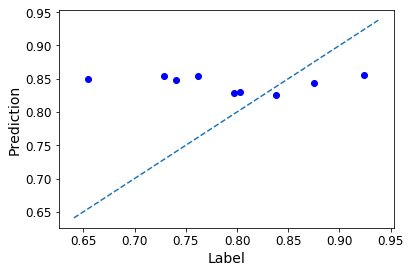

In [131]:
for label in labels:
    X_nonNA, y_nonNA = remove_NAs(X, y, label)
    X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X_nonNA, y_nonNA, test_size=0.15)
    
    display_set(X_TRAIN, X_TEST, Y_TRAIN, Y_TEST)
        
    Ypipeline, XYpipeline = retrieve_pipelines("rfs_model", RandomForestRegressor(n_estimators=500, max_leaf_nodes=16, n_jobs=8))
    
    y_test_np, y_prediction, this_y_train_tr = train_and_test(Ypipeline, XYpipeline, X_TRAIN, X_TEST, Y_TRAIN.values, Y_TEST.values)

    rmse, r, t = simple_score(y_test_np, y_prediction)
    
    print("RMSE: " + str(rmse))
    print("Pearson: " + str(r))
    print("Spearman: " + str(t))

    #scores = cv_score(XYpipeline, X_TRAIN, this_y_train_tr)
    
    #print("CV Scores: " + str(scores))
    #print("CV Mean: " + str(scores.mean()))
    #print("CV STD: " + str(scores.std()))
             
    visualize(y_test_np, y_prediction)


### Bootstrap Regression Model

RMSE: 0.0888520105669
Pearson: (0.30258336170477418, 0.015935643612153261)
Spearman: SpearmanrResult(correlation=0.21382184077552904, pvalue=0.092434177708721393)


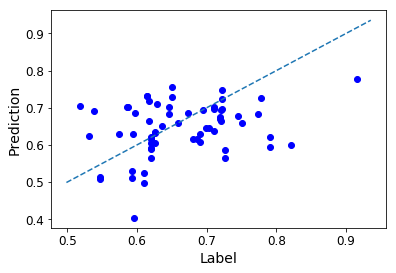

RMSE: 0.0856807726821
Pearson: (0.17226334532057744, 0.1770048546601522)
Spearman: SpearmanrResult(correlation=0.13966166880078895, pvalue=0.274968135579924)


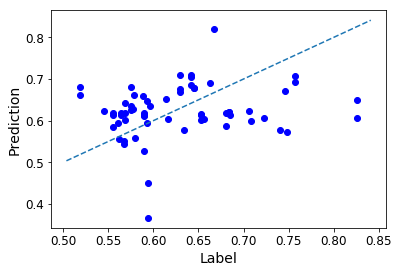

RMSE: 0.0983211439878
Pearson: (-0.15410597684957142, 0.22785471785655889)
Spearman: SpearmanrResult(correlation=-0.14115361594923423, pvalue=0.26982198410435371)


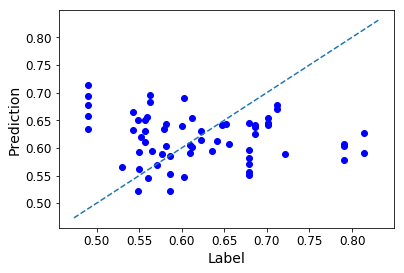

RMSE: 0.0996197383583
Pearson: (0.1171956115769623, 0.39868567136940114)
Spearman: SpearmanrResult(correlation=0.18041415914883133, pvalue=0.19172645338087749)


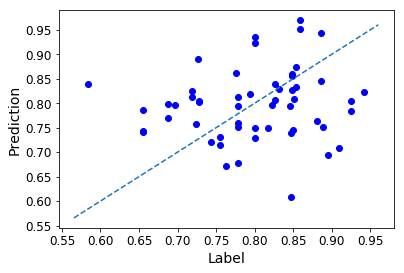

RMSE: 0.102683046824
Pearson: (-0.23076295869725777, 0.093187373043928323)
Spearman: SpearmanrResult(correlation=-0.26119465403804393, pvalue=0.056425884303027009)


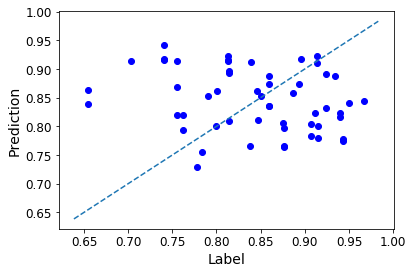

In [133]:
for label in labels:
    X_nonNA, y_nonNA = remove_NAs(X, y, label)
    
    all_y_test_np = np.array([])
    all_y_prediction = np.array([])
    for i in range(1,10):
        X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X_nonNA, y_nonNA, test_size=0.10)

        Ypipeline, XYpipeline = retrieve_pipelines("ridge_model", Ridge(alpha = 0.50))

        y_test_np, y_prediction, _ = train_and_test(Ypipeline, XYpipeline, X_TRAIN, X_TEST, Y_TRAIN.values, Y_TEST.values)
        all_y_test_np = np.append(all_y_test_np, y_test_np)
        all_y_prediction = np.append(all_y_prediction, y_prediction)
        
    rmse, r, t = simple_score(all_y_test_np, all_y_prediction)
    
    print("RMSE: " + str(rmse))
    print("Pearson: " + str(r))
    print("Spearman: " + str(t))
    visualize(all_y_test_np, all_y_prediction)


### Bootstrap Random Forest Model

c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

RMSE: 0.0711386310753
Pearson: (0.040834599131047145, 0.75066944258546786)
Spearman: SpearmanrResult(correlation=0.013880219025600857, pvalue=0.91401963396027708)


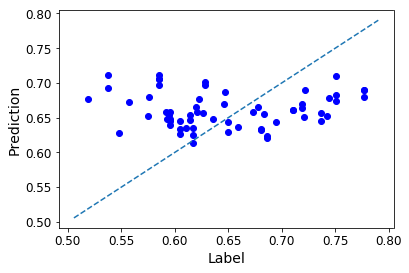

c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

RMSE: 0.0739350736649
Pearson: (-0.23759096381020947, 0.060792367957492835)
Spearman: SpearmanrResult(correlation=-0.23424052128434777, pvalue=0.064632053873727918)


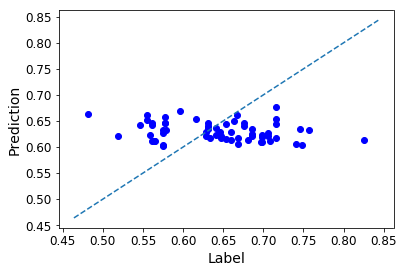

c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

RMSE: 0.0719370092654
Pearson: (0.07282283037777533, 0.57058337468394549)
Spearman: SpearmanrResult(correlation=0.12200249655077749, pvalue=0.34082426941957478)


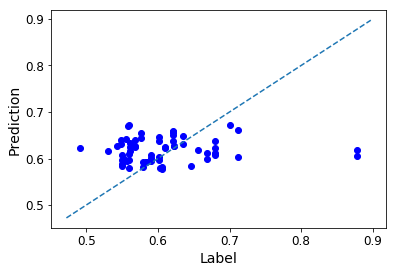

c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

RMSE: 0.0910053559737
Pearson: (-0.014857724090135508, 0.91508042660663702)
Spearman: SpearmanrResult(correlation=-0.0018684106390683697, pvalue=0.98930172874597067)


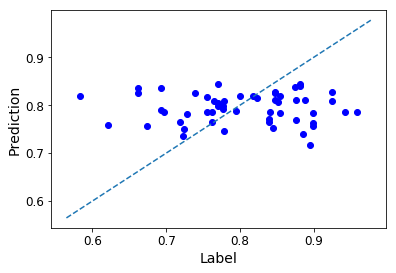

c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

RMSE: 0.0883163059969
Pearson: (-0.28661689327777146, 0.035621802193783837)
Spearman: SpearmanrResult(correlation=-0.27144630789296198, pvalue=0.047089664310731201)


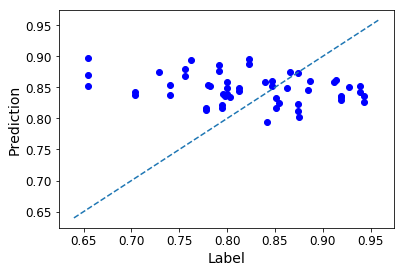

In [40]:
for label in labels:
    X_nonNA, y_nonNA = remove_NAs(X, y, label)
    
    all_y_test_np = np.array([])
    all_y_prediction = np.array([])
    for i in range(1,10):
        X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X_nonNA, y_nonNA, test_size=0.10)

        Ypipeline, XYpipeline = retrieve_pipelines("rfs_model", RandomForestRegressor(n_estimators=1000, max_leaf_nodes=8, n_jobs=4))

        y_test_np, y_prediction, _ = train_and_test(Ypipeline, XYpipeline, X_TRAIN, X_TEST, Y_TRAIN.values, Y_TEST.values)
        all_y_test_np = np.append(all_y_test_np, y_test_np)
        all_y_prediction = np.append(all_y_prediction, y_prediction)
        
    rmse, r, t = simple_score(all_y_test_np, all_y_prediction)
    
    print("RMSE: " + str(rmse))
    print("Pearson: " + str(r))
    print("Spearman: " + str(t))
    visualize(all_y_test_np, all_y_prediction)
